In [112]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [113]:
import matplotlib.pyplot as plt
import numpy as np

import torch

from itertools import product
from itertools import combinations
import pickle
import datetime

from scipy.special import logsumexp

from Bio.Phylo.TreeConstruction import _DistanceMatrix
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor
from Bio.Phylo.TreeConstruction import DistanceCalculator
from io import StringIO
from Bio import Phylo

from tree_torch import Tree
from SLCVI_torch import SLCVI

import warnings
warnings.filterwarnings('ignore')

from copy import deepcopy

np.random.seed(0)

In [114]:
data_set = "DS1"
pop_size = 5.0 # exponential parameter for constant pop size prior
data_file = '../dat/'+data_set+'/'+data_set+'.pickle'
time = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')
reparam_file = '../results/'+data_set+'/'+data_set+'_'+time+'_reparam.pickle'
reinforce_file = '../results/'+data_set+'/'+data_set+'_'+time+'_reinforce.pickle'
VIMCO_file = '../results/'+data_set+'/'+data_set+'_'+time+'_VIMCO.pickle'

In [115]:
with open(data_file, 'rb') as f:
    DS1 = pickle.load(f)

In [116]:
genomes = []
species = []
for key in DS1:
    genomes.append(DS1[key])
    species.append(key)
    
n_species = len(species)

In [117]:
# From https://github.com/zcrabbit/vbpi-torch/blob/ff86cf0c47a5753f5cc5b4dfe0b6ed783ab22669/unrooted/phyloModel.py#L7-L11
nuc2vec = {'A':[1.,0.,0.,0.], 'G':[0.,1.,0.,0.], 'C':[0.,0.,1.,0.], 'T':[0.,0.,0.,1.],
           '-':[1.,1.,1.,1.], '?':[1.,1.,1.,1.], 'N':[1.,1.,1.,1.], 'R':[1.,1.,0.,0.],
           'Y':[0.,0.,1.,1.], 'S':[0.,1.,1.,0.], 'W':[1.,0.,0.,1.], 'K':[0.,1.,0.,1.],
           'M':[1.,0.,1.,0.], 'B':[0.,1.,1.,1.], 'D':[1.,1.,0.,1.], 'H':[1.,0.,1.,1.],
           'V':[1.,1.,1.,0.], '.':[1.,1.,1.,1.], 'U':[0.,0.,0.,1.]}

tree_log_probs = torch.tensor([[nuc2vec[g] for g in genome] for genome in genomes],
                                dtype = torch.float64)
tree_log_probs = torch.log(tree_log_probs)

# Set initial $\theta$ using the consesus tree from BEAST

In [118]:
times = 0.05 * torch.ones((27,27))

# A Homo-sapiens, mus, rattus, Oryct
times[10,15] = 0.0061
times[10,17] = 0.0093
times[15,19] = 0.0042

# B Trach 23, Alligator 0, Scel 21, Hetero 9, Gallus 6, Turdus 24
times[0,23] = 0.0049
times[9,21] = 0.0072
times[0,9] = 0.0111
times[6,24] = 0.0076
times[6,23] = 0.0203

# C Disco 4, Amph 2, Hypo 12, Grand 8, Ich 13, Pleth 18, Sca 20
times[4,12] = 0.0141
times[2,12] = 0.0082
times[8,12] = 0.0028
times[12,13] = 0.01
times[18,13] = 0.0114
times[18,20] = 0.0052

# D Typh 25, siren 22, Amb 1
times[1,22] = 0.0053
times[1,25] = 0.0098

# E Neso 16, Eleu 5, Gatro 7, Hyla 11, Bufo 3
times[5,16] = 0.0138
times[5,7] = 0.0175
times[3,11] = 0.0157
times[3,16] = 0.0207

# A B
times[10,23] = 0.0312

# C D
times[4,22] = 0.0165

# CDE
times[5,22] = 0.0229

# CDE Xeno 26 Lat 14
times[5,26] = 0.0278
times[5,14] = 0.0348

# ABCDE
times[5,10] = 0.0406

In [119]:
theta = torch.zeros((2,n_species,n_species))
log_times = torch.log(times)

tree = Tree(theta,log_times,tree_log_probs,
            pop_size=pop_size)

for node in tree.nodes:
    combs = combinations(node.leaves,2)
    for inds in combs:
        inds = sorted(inds)
        theta[0,inds[1],inds[0]] = min(theta[0,inds[1],inds[0]],np.log(node.coal_time))
        theta[1,inds[1],inds[0]] = -2
        
print(theta.shape)

torch.Size([2, 27, 27])


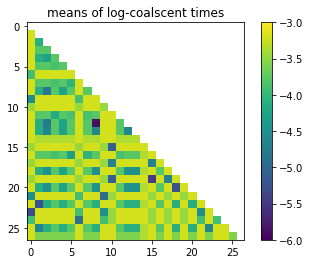

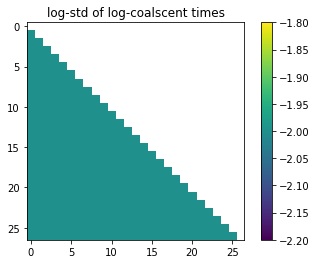

In [120]:
m = deepcopy(theta[0])
m[np.triu_indices(m.shape[0])] = np.nan
plt.imshow(m,vmin = -6, vmax = -3)
plt.title("means of log-coalscent times")
plt.colorbar()
plt.show()

log_sig = deepcopy(theta[1])
log_sig[np.triu_indices(log_sig.shape[0])] = np.nan
plt.imshow(log_sig)
plt.title("log-std of log-coalscent times")
plt.colorbar()
plt.show()

# Set initial $\theta$ using expected number of changes

In [121]:
times = torch.zeros((n_species,n_species))

for i in range(n_species):
    for j in range(n_species):
        eq = [x != y for x,y in zip(genomes[i],genomes[j]) if ((x in ["A","C","T","G"]) and (y in ["A","C","T","G"]))]
        p_hat = np.mean(eq)
        
        times[i,j] = np.mean(eq)

In [122]:
log_times = torch.log(times)
log_times = log_times + torch.triu(torch.full((n_species,n_species), float("Inf")))


tree = Tree(theta,log_times,tree_log_probs,
            pop_size=pop_size)

theta = torch.zeros((2,n_species,n_species))

for node in tree.nodes:
    combs = combinations(node.leaves,2)
    for inds in combs:
        inds = sorted(inds)
        theta[0,inds[1],inds[0]] = min(theta[0,inds[1],inds[0]],torch.log(node.coal_time))
        theta[1,inds[1],inds[0]] = -2
        
print(theta.shape)

torch.Size([2, 27, 27])


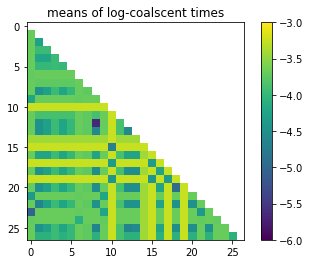

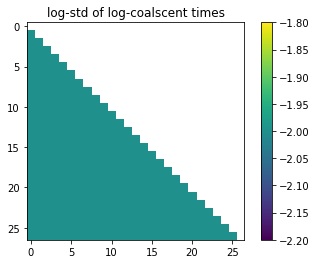

In [123]:
m = deepcopy(theta[0])
m[np.triu_indices(m.shape[0])] = np.nan
plt.imshow(m,vmin = -6, vmax = -3)
plt.title("means of log-coalscent times")
plt.colorbar()
plt.show()

log_sig = deepcopy(theta[1])
log_sig[np.triu_indices(log_sig.shape[0])] = np.nan
plt.imshow(log_sig)
plt.title("log-std of log-coalscent times")
plt.colorbar()
plt.show()

# Make Neighbor Joining initial guess

In [126]:
times = np.zeros((n_species,n_species))

for i in range(n_species):
    for j in range(n_species):
        eq = [x != y for x,y in zip(genomes[i],genomes[j]) if ((x in ["A","C","T","G"]) and (y in ["A","C","T","G"]))]
        p_hat = np.mean(eq)
        
        times[i,j] = np.mean(eq)

matrix = []
for i,row in enumerate(times):
    matrix.append(list(row[:(i+1)]))
m = _DistanceMatrix(species, matrix)
calculator = DistanceCalculator('identity')
constructor = DistanceTreeConstructor(calculator, 'nj')
tree = constructor.nj(m)

theta = np.zeros((2,n_species,n_species))
for i in range(n_species):
    for j in range(i):
        theta[0,i,j] = np.log(tree.distance(target1=species[i],target2=species[j]))
        theta[1,i,j] = -2

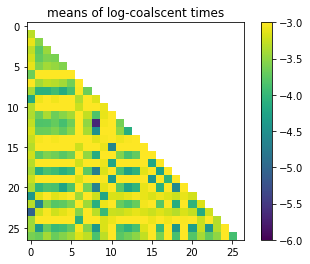

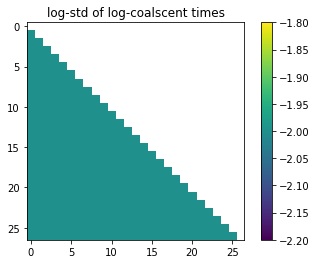

In [127]:
m = deepcopy(theta[0])
m[np.triu_indices(m.shape[0])] = np.nan
plt.imshow(m,vmin = -6, vmax = -3)
plt.title("means of log-coalscent times")
plt.colorbar()
plt.show()

log_sig = deepcopy(theta[1])
log_sig[np.triu_indices(log_sig.shape[0])] = np.nan
plt.imshow(log_sig)
plt.title("log-std of log-coalscent times")
plt.colorbar()
plt.show()

# perform variational inference

iteration:  0
runtime: 0 mins
grad_norm estimate:  434.6090645997335
ELBO estimate:  -7490.626991767148

iteration:  10
runtime: 0 mins
grad_norm estimate:  266.13766272864933
ELBO estimate:  -7406.787896692397

iteration:  20
runtime: 0 mins
grad_norm estimate:  238.9146411366877
ELBO estimate:  -7350.7859026367505

iteration:  30
runtime: 1 mins
grad_norm estimate:  214.54076184859213
ELBO estimate:  -7308.273933425135

iteration:  40
runtime: 1 mins
grad_norm estimate:  255.87590619959454
ELBO estimate:  -7275.1402951346045

iteration:  50
runtime: 1 mins
grad_norm estimate:  407.7667408708427
ELBO estimate:  -7258.553285404135

iteration:  60
runtime: 1 mins
grad_norm estimate:  418.60450437509354
ELBO estimate:  -7233.546562976905

iteration:  70
runtime: 2 mins
grad_norm estimate:  121.6559449569192
ELBO estimate:  -7232.9648619139025

iteration:  80
runtime: 2 mins
grad_norm estimate:  108.43576676533962
ELBO estimate:  -7218.849232426493

iteration:  90
runtime: 2 mins
grad_nor

iteration:  760
runtime: 878 mins
grad_norm estimate:  69.97193133339384
ELBO estimate:  -7162.497026093145

iteration:  770
runtime: 878 mins
grad_norm estimate:  69.27931962230366
ELBO estimate:  -7162.71471138733

iteration:  780
runtime: 878 mins
grad_norm estimate:  44.542666891956465
ELBO estimate:  -7162.092828492044

iteration:  790
runtime: 879 mins
grad_norm estimate:  85.06608196924243
ELBO estimate:  -7162.671102297277

iteration:  800
runtime: 879 mins
grad_norm estimate:  49.17459824371873
ELBO estimate:  -7162.412305513334

iteration:  810
runtime: 879 mins
grad_norm estimate:  58.47830693396919
ELBO estimate:  -7161.175790225076

iteration:  820
runtime: 880 mins
grad_norm estimate:  57.30280158559816
ELBO estimate:  -7161.405671134308

iteration:  830
runtime: 880 mins
grad_norm estimate:  113.42820826169184
ELBO estimate:  -7161.9686912929865

iteration:  840
runtime: 880 mins
grad_norm estimate:  50.687751818855894
ELBO estimate:  -7162.929417043689

iteration:  850


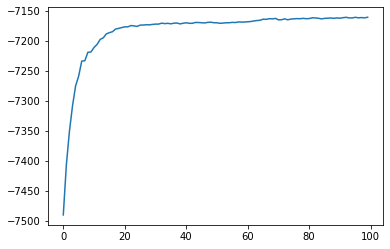

In [129]:
optim_reparam = SLCVI(tree_log_probs,deepcopy(theta),pop_size)
optim_reparam.learn(batch_size=10,
                    iters=1000,
                    alpha=0.01,
                    method="reparam",
                    record_every=10,
                    pop_size=pop_size)

print("final theta:",optim_reparam.theta)
print("final gradient:",optim_reparam.theta.grad)
plt.plot(optim_reparam.ELBO_ests)

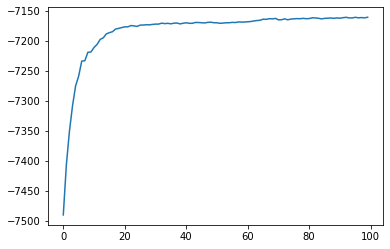

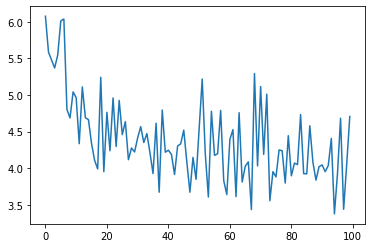

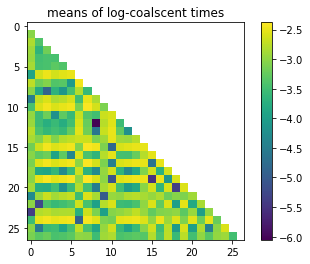

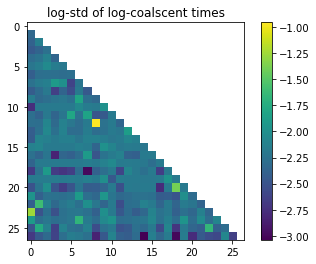

In [130]:
plt.plot(optim_reparam.ELBO_ests)
plt.show()
plt.plot(np.log(optim_reparam.grad_norms))
plt.show()

m = deepcopy(optim_reparam.theta[0].detach())
m[np.triu_indices(m.shape[0])] = np.nan
plt.imshow(m)
plt.title("means of log-coalscent times")
plt.colorbar()
plt.show()

log_sig = deepcopy(optim_reparam.theta[1].detach())
log_sig[np.triu_indices(log_sig.shape[0])] = np.nan
plt.imshow(log_sig)
plt.title("log-std of log-coalscent times")
plt.colorbar()
plt.show()

In [131]:
with open(reparam_file, 'wb') as file: 
    pickle.dump(optim_reparam, file) 

PicklingError: Can't pickle <class 'SLCVI_torch.SLCVI'>: it's not the same object as SLCVI_torch.SLCVI

In [132]:
optim_reinforce = SLCVI(tree_log_probs,deepcopy(theta),pop_size)
optim_reinforce.learn(batch_size=10,
                      iters=1000,
                      alpha=0.01,
                      method="reinforce",
                      record_every=10,
                      pop_size=pop_size)

print("final theta:",optim_reinforce.theta)
print("final gradient:",optim_reinforce.theta.grad)
plt.plot(optim_reinforce.ELBO_ests)

iteration:  0
runtime: 0 mins
grad_norm estimate:  817.5942544636462
ELBO estimate:  -7499.582463637448



KeyboardInterrupt: 

In [ ]:
plt.plot(optim_reinforce.ELBO_ests)
plt.show()
plt.plot(np.log(optim_reinforce.grad_norms))
plt.show()

m = deepcopy(optim_reinforce.theta[0].detach())
m[np.triu_indices(m.shape[0])] = np.nan
plt.imshow(m)
plt.title("means of log-coalscent times")
plt.colorbar()
plt.show()

log_sig = deepcopy(optim_reinforce.theta[1].detach())
log_sig[np.triu_indices(log_sig.shape[0])] = np.nan
plt.imshow(log_sig)
plt.title("log-std of log-coalscent times")
plt.colorbar()

In [ ]:
with open(reinforce_file, 'wb') as file: 
    pickle.dump(optim_reinforce, file) 

In [ ]:
optim_VIMCO = SLCVI(tree_log_probs,deepcopy(theta),pop_size)
optim_VIMCO.learn(batch_size=10,
                  iters=1000,
                  alpha=0.01,
                  method="VIMCO",
                  record_every=10,
                  test_batch_size=100,
                  pop_size=pop_size)

print("final theta:",optim_VIMCO.theta)
print("final gradient:",optim_VIMCO.theta.grad)
plt.plot(optim_VIMCO.ELBO_ests)

In [ ]:
plt.plot(optim_VIMCO.ELBO_ests)
plt.show()
plt.plot(np.log(optim_VIMCO.grad_norms))
plt.show()

m = deepcopy(optim_VIMCO.theta[0].detach())
m[np.triu_indices(m.shape[0])] = np.nan
plt.imshow(m)
plt.title("means of log-coalscent times")
plt.colorbar()
plt.show()

log_sig = deepcopy(optim_VIMCO.theta[1].detach())
log_sig[np.triu_indices(log_sig.shape[0])] = np.nan
plt.imshow(log_sig)
plt.title("log-std of log-coalscent times")
plt.colorbar()

In [ ]:
with open(reinforce_file, 'wb') as file: 
    pickle.dump(optim_VIMCO, file) 

In [102]:
optim = optim_reinforce
theta = optim.theta

# draw the random tree using a newick file

In [43]:
def write_newick(node):

    if node.children == []:
        return species[next(iter(node.leaves))] + ":" + str(node.parent.coal_time.item())
    elif node.parent is None:
        return "(" + write_newick(node.children[0]) + "," + write_newick(node.children[1]) + ")"
    else:
        bl = node.parent.coal_time.item() - node.coal_time.item()
        return "(" + write_newick(node.children[0]) + "," + write_newick(node.children[1]) + "):" + str(bl)

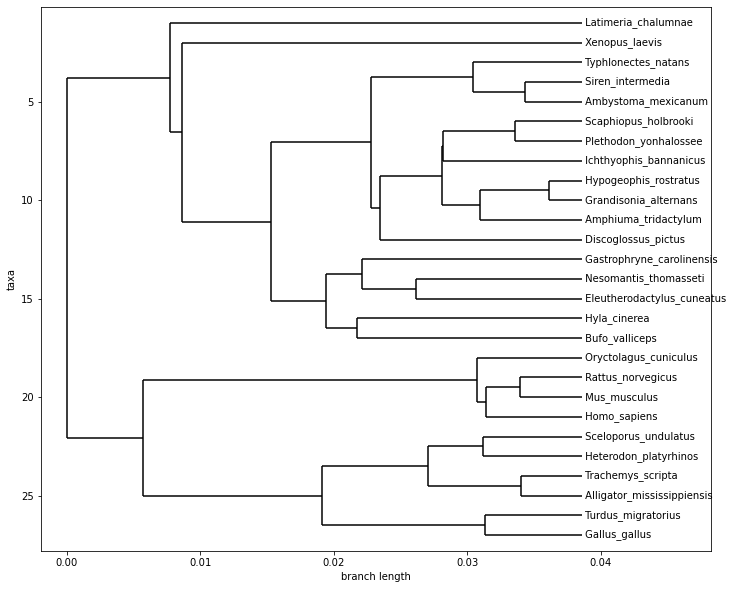

-6992.3994888863
-42.48988426192403
-7034.889373148224


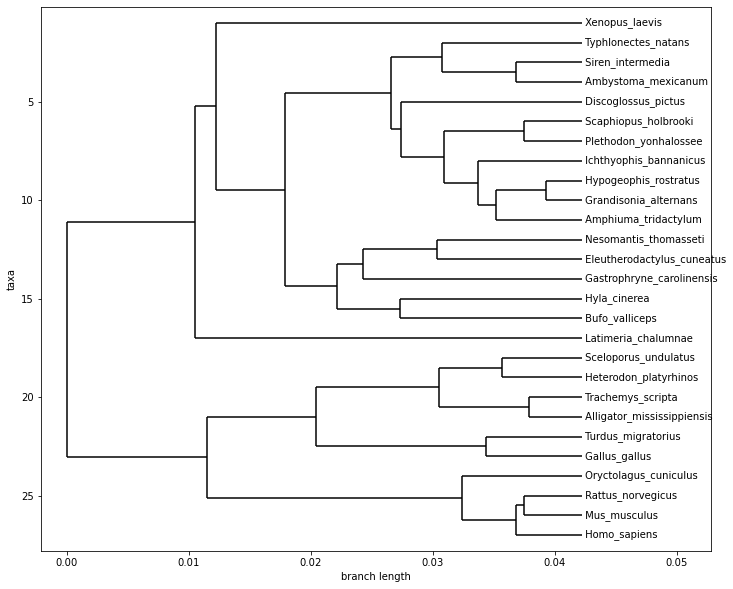

-6982.417212142541
-42.500718148476004
-7024.917930291017


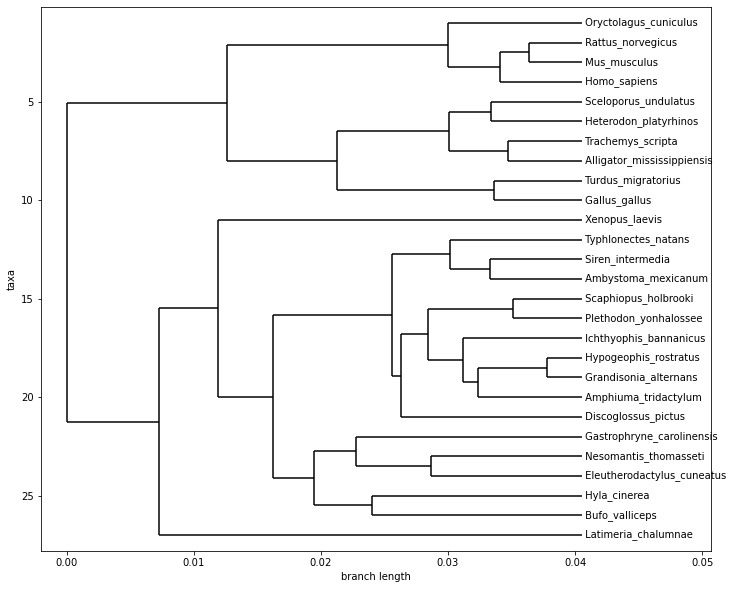

-6973.750711843848
-42.51802070376744
-7016.268732547615


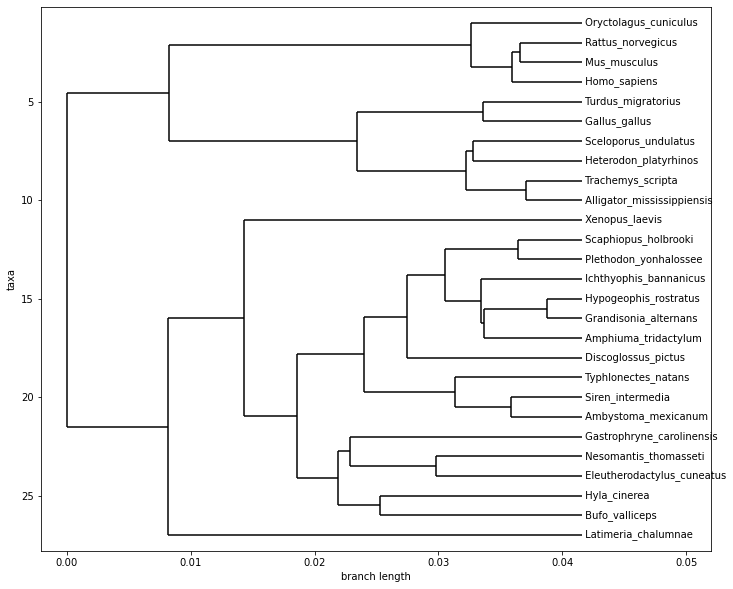

-6978.754761056863
-42.502771920331334
-7021.257532977194


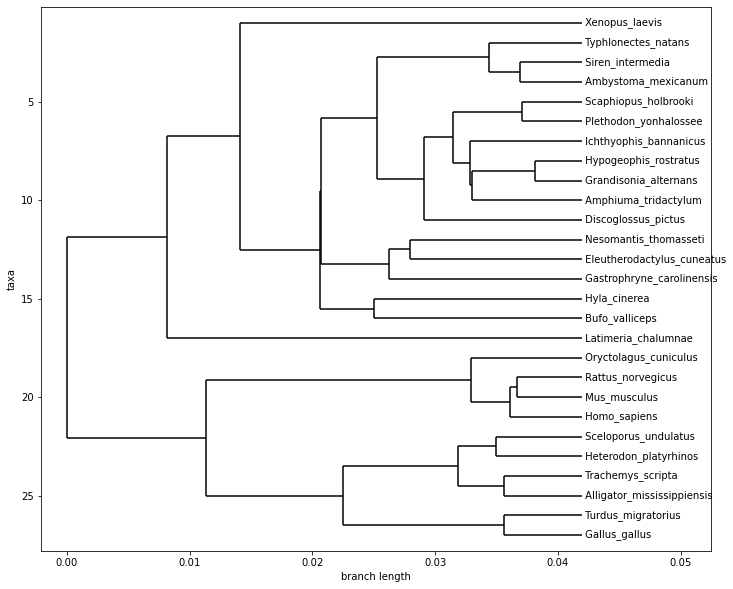

-6982.388185774799
-42.497939140758675
-7024.886124915558


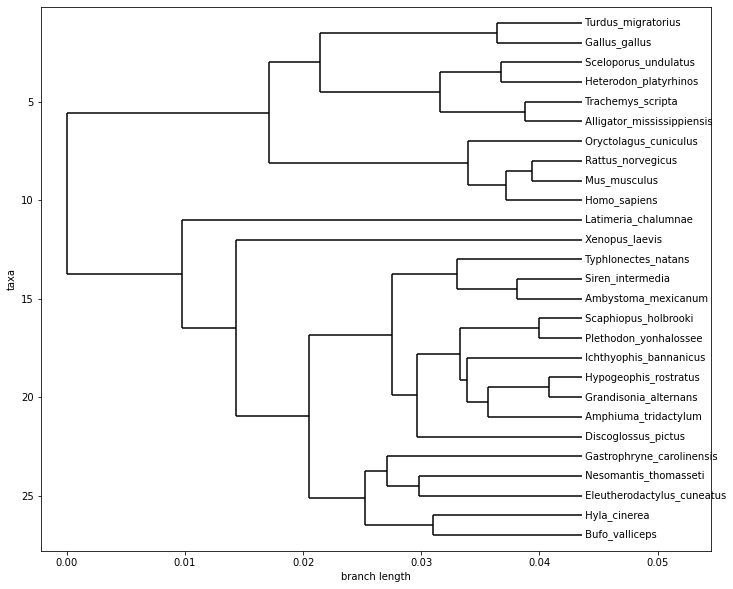

-6979.660744458551
-42.49024118163409
-7022.150985640184


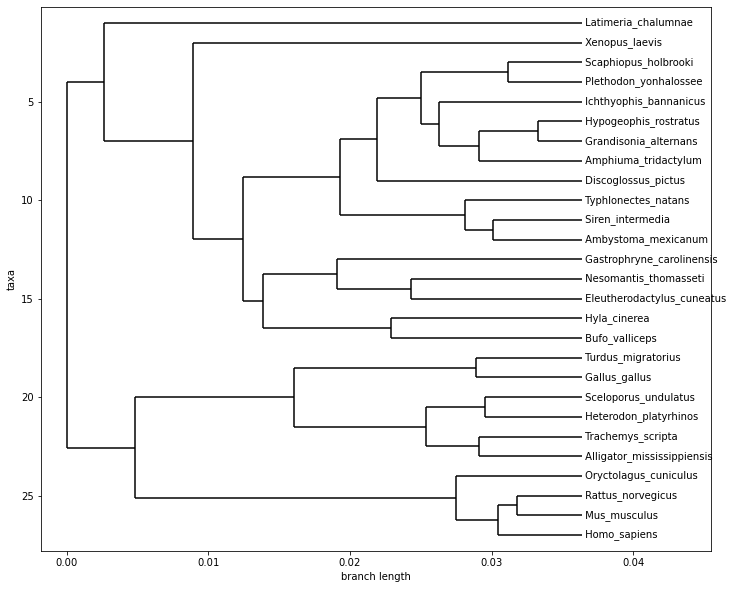

-6974.39239447681
-42.50949179690613
-7016.901886273717


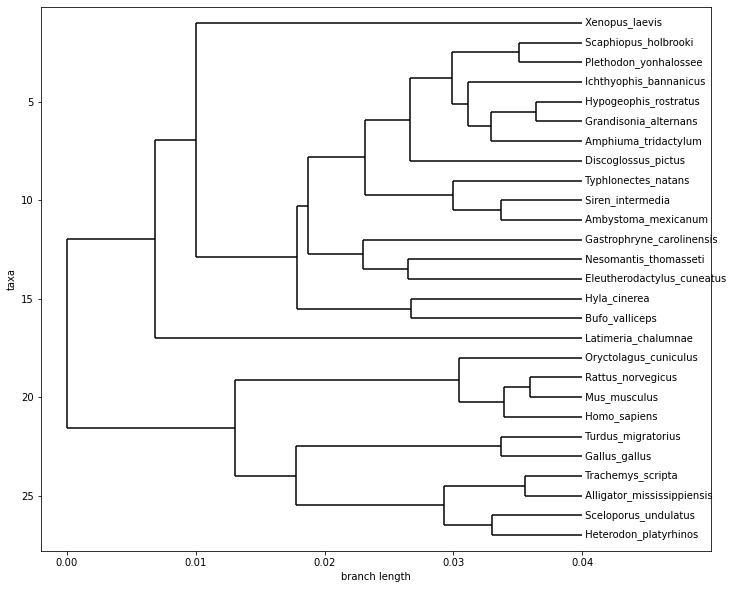

-6984.327405929037
-42.487770984203294
-7026.81517691324


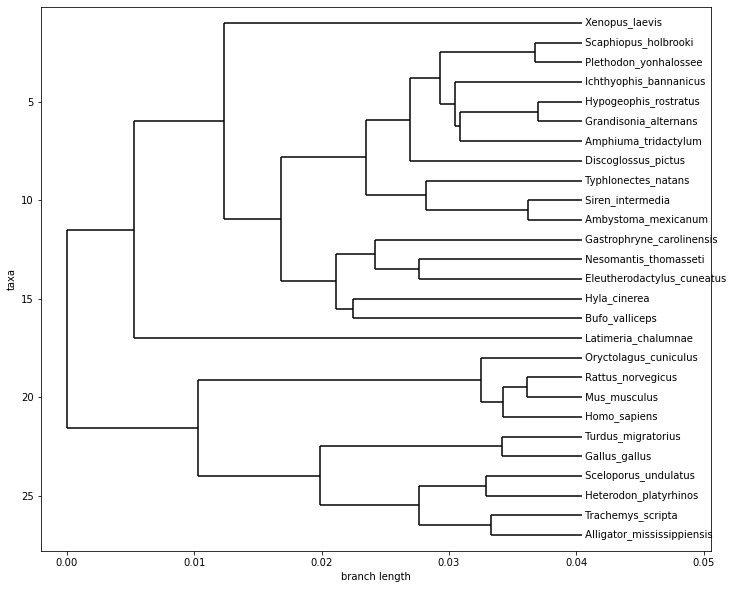

-6974.06652235279
-42.51562313581678
-7016.582145488607


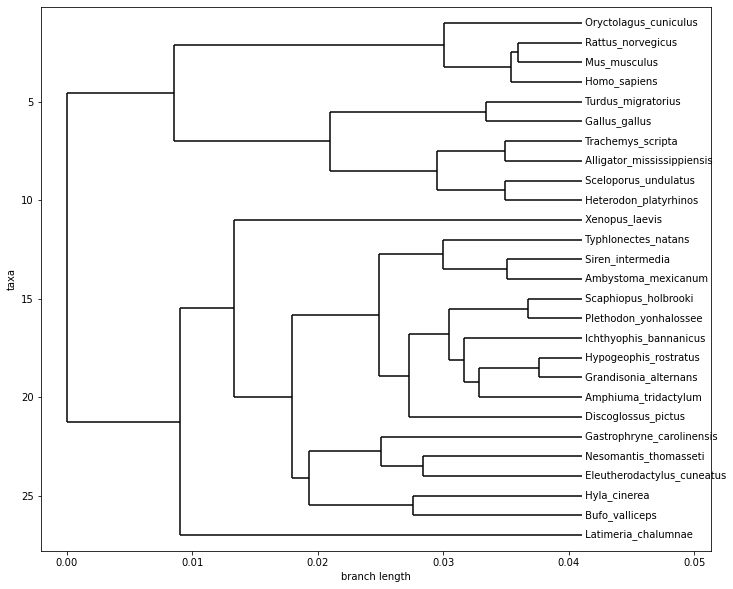

-6973.682376066026
-42.51166902385849
-7016.194045089885


In [45]:
for _ in range(10):
    Z = torch.normal(mean=0.0,std=1.0,size=(n_species,n_species))
    log_times = torch.exp(theta[1])*Z+theta[0]
    log_times = log_times + torch.triu(torch.full((n_species,n_species), float("Inf")))

    tree = Tree(theta,log_times,tree_log_probs,
                pop_size=pop_size)

    treedata = write_newick(tree.nodes[-1])
    handle = StringIO(treedata)
    tree_to_draw = Phylo.read(handle, "newick")

    # Set up the plot
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(1, 1, 1)

    # Draw the phylogenetic tree
    Phylo.draw(tree_to_draw, axes=ax)

    print(tree.log_like.item())
    print(tree.log_prior.item())
    print(tree.log_p.item())

# Estimate the marginal likelihood

In [103]:
n_exp = 10
n_samples = 100

# get priors and log-liklihoods
priors = []
LL = []

# get log_qs
log_qs = []

# get root heights
rootHeights = []

# get tree topologies
tree_hash = {}
top_counts = {}

# get marginal log-likelihoods and ELBOs
MLL_all = np.zeros(n_exp)
ELBO_all = np.zeros(n_exp)

with torch.no_grad():
    for i in range(n_exp):

        print(i)
        MLL = np.zeros(n_samples)
        ELBO = np.zeros(n_samples)

        for j in range(n_samples):
            Z = torch.normal(mean=0.0,std=1.0,size=(n_species,n_species))
            log_times = torch.exp(theta[1])*Z+theta[0]
            log_times = log_times + torch.triu(torch.full((n_species,n_species), float("Inf")))
            tree = Tree(optim.theta,
                        log_times,
                        deepcopy(tree_log_probs),
                        pop_size=pop_size)

            MLL[j] = tree.log_p.item() - tree.log_q.item()
            ELBO[j] = tree.log_p.item() - tree.log_q.item()

            LL.append(tree.log_like.item())
            priors.append(tree.log_prior.item())
            log_qs.append(tree.log_q.item())
            rootHeights.append(tree.nodes[-1].coal_time.item())

            tree_top = frozenset([frozenset(x.leaves) for x in tree.nodes])
            if tree_top in tree_hash:
                top_counts[tree_hash[tree_top]] += 1
            else:
                tree_hash[tree_top] = len(tree_hash)
                top_counts[tree_hash[tree_top]] = 1

        MLL_all[i] = logsumexp(MLL) - np.log(n_samples)
        ELBO_all[i] = np.mean(ELBO)

0
1
2
3
4
5
6
7
8
9


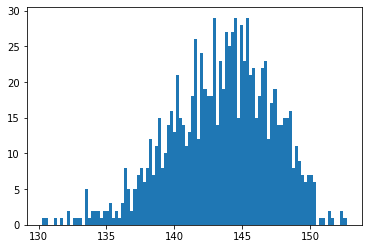

143.46433505458214


In [104]:
plt.hist(log_qs,bins = 100)
plt.show()
print(np.mean(log_qs))

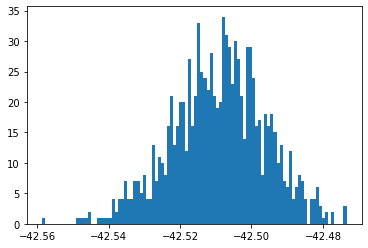

-42.50910236394554


In [105]:
plt.hist(priors,bins = 100)
plt.show()
print(np.mean(priors))

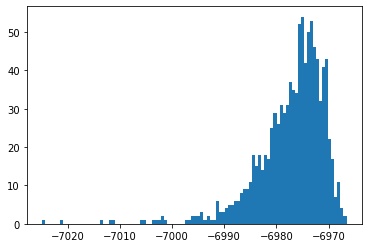

-6977.177121521376


In [106]:
plt.hist(LL,bins = 100)
plt.show()
print(np.mean(LL))

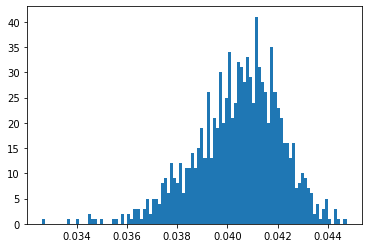

0.04042246175528179


In [107]:
plt.hist(rootHeights,bins = 100)
plt.show()
print(np.mean(rootHeights))

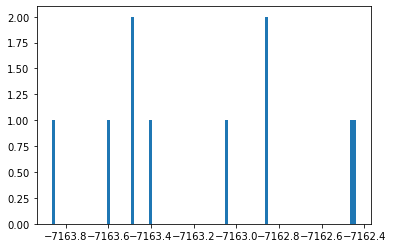

-7163.150558939904


In [108]:
plt.hist(ELBO_all,bins = 100)
plt.show()
print(np.mean(ELBO_all))

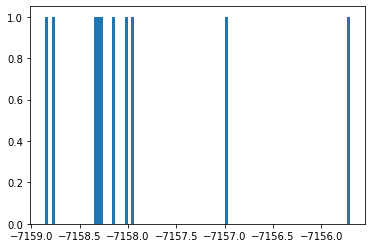

-7157.934354856084


In [109]:
plt.hist(MLL_all,bins = 100)
plt.show()
print(np.mean(MLL_all))

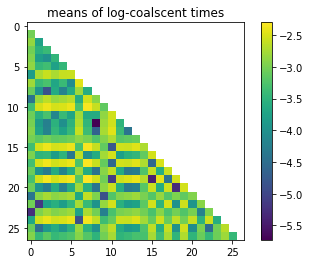

In [110]:
m = deepcopy(theta[0].detach())
m[np.triu_indices(m.shape[0])] = np.nan
plt.imshow(m)
plt.title("means of log-coalscent times")
plt.colorbar()

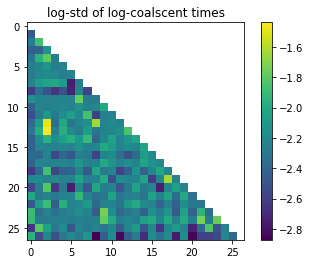

In [111]:
log_sig = deepcopy(theta[1].detach())
log_sig[np.triu_indices(log_sig.shape[0])] = np.nan
plt.imshow(log_sig)
plt.title("log-std of log-coalscent times")
plt.colorbar()